In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 7.3 MB/s 
     |████████████████████████████████| 15.7 MB 48.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.5.3 which is incompatible.
lucid 0.3.10 requires numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff
import keras
import segmentation_models as sm
import tensorflow as tf

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
mask_stack = tiff.imread('/content/drive/MyDrive/CAPSTONE/panda/50_panda_mask_stack.tif')
image_stack = tiff.imread('/content/drive/MyDrive/CAPSTONE/panda/50_panda_image_stack.tif')

In [ ]:
print(image_stack.shape) #55 image with size of 256 kali 256 

(50, 256, 256, 3)


In [ ]:
all_img_patches = []
for img in range(image_stack.shape[0]):
  #print(img)
  image = image_stack[img]
  patches_img = patchify(image, (256, 256, 3), step=256)
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i, j, 0, :, :, :]
      single_patch_img = (single_patch_img.astype('float32')) / 255.

      all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
#images = np.stack((images,)*3, axis = 1) My image already have a 3 dim 

all_mask_patches = []
for img in range(mask_stack.shape[0]):
  mask = mask_stack[img]
  patches_mask = patchify(mask, (256, 256), step=256)
  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask = patches_mask[i,j,:,:]
      single_patch_mask = single_patch_mask / 255.

      all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)
print(masks.shape)

(50, 256, 256, 1)


In [ ]:
print(images.shape)
print(masks.shape)
print("Pixel values in the masks are:", np.unique(masks))

(50, 256, 256, 3)
(50, 256, 256, 1)
Pixel values in the masks are: [0. 1.]


In [ ]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

images1=preprocess_input1(images)
print(images1.shape)

(50, 256, 256, 3)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(37, 256, 256, 3)
(13, 256, 256, 3)


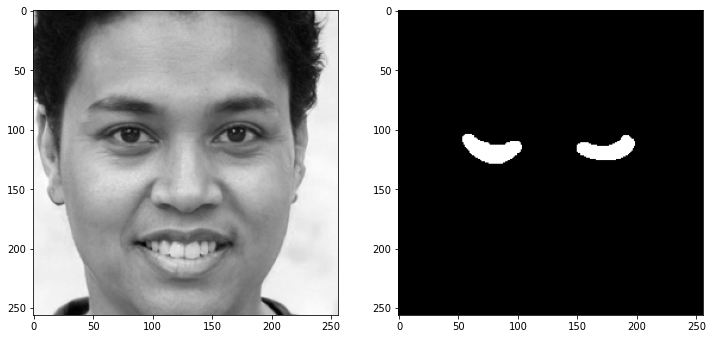

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
seed = 38
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed = seed)
                         
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


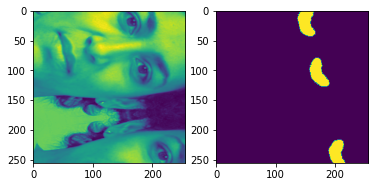

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
model = sm.Unet('resnet34', encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, tf.keras.metrics.Precision()])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

85524480/85521592 [==============================] - 2s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
_________________________________________________

In [ ]:
#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=100)


Epoch 1/100
50/50 [==============================] - 51s 1s/step - loss: 1.1350 - iou_score: 0.1243 - precision: 0.1837 - val_loss: 1.2708 - val_iou_score: 0.0526 - val_precision: 0.3407
Epoch 2/100
50/50 [==============================] - 32s 636ms/step - loss: 1.0783 - iou_score: 0.1332 - precision: 0.3255 - val_loss: 1.3713 - val_iou_score: 0.0563 - val_precision: 0.2704
Epoch 3/100
50/50 [==============================] - 32s 643ms/step - loss: 0.9953 - iou_score: 0.2016 - precision: 0.2276 - val_loss: 1.3498 - val_iou_score: 0.0176 - val_precision: 0.2741
Epoch 4/100
50/50 [==============================] - 32s 637ms/step - loss: 0.9671 - iou_score: 0.2410 - precision: 0.2852 - val_loss: 1.7821 - val_iou_score: 0.0013 - val_precision: 0.3247
Epoch 5/100
50/50 [==============================] - 32s 630ms/step - loss: 0.9537 - iou_score: 0.2604 - precision: 0.3287 - val_loss: 2.0350 - val_iou_score: 0.0479 - val_precision: 0.3059
Epoch 6/100
50/50 [==============================] -

In [ ]:
model.save('/content/drive/MyDrive/CAPSTONE/h5/Panda_ResUnet_100epoch.h5')

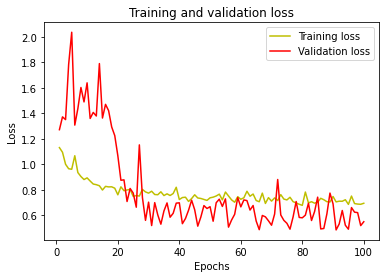

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



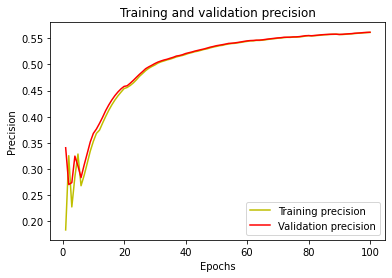

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['precision']
val_loss = history.history['val_precision']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training precision')
plt.plot(epochs, val_loss, 'r', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

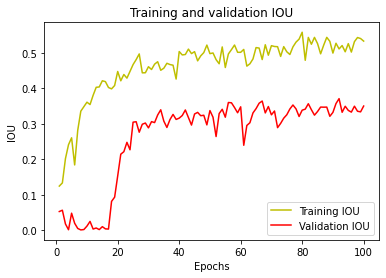

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.664375234521576


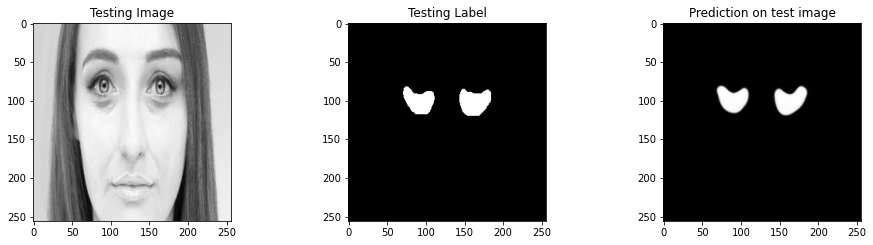

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

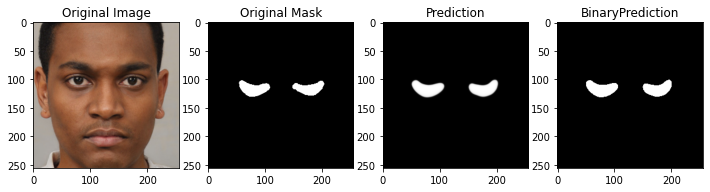

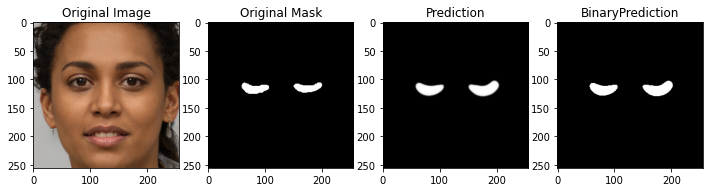

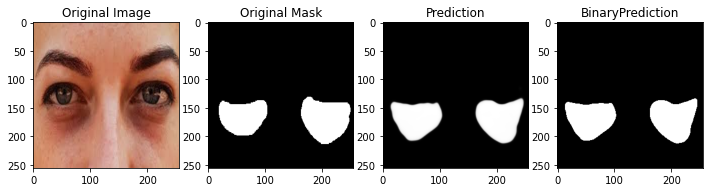

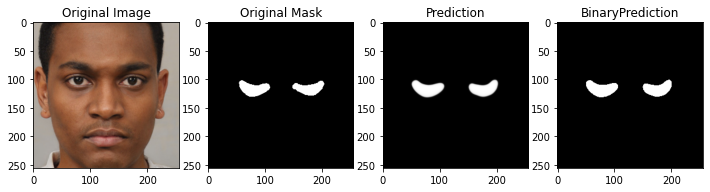

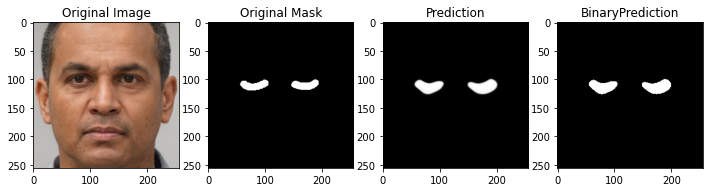

In [ ]:
for i in range(5):
  
  test_img_number = random.randint(0, len(X_test)-1)
  test_img = X_test[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  ground_truth=y_test[test_img_number]
  prediction = model.predict(test_img_input)
  prediction = prediction[0,:,:,0]


  plt.figure(figsize=(12,12))
  plt.subplot(1,4,1)
  plt.imshow(np.squeeze(test_img))
  plt.title('Original Image')
  plt.subplot(1,4,2)
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.title('Original Mask')
  plt.subplot(1,4,3)
  plt.imshow(np.squeeze(prediction), cmap='gray')
  plt.title('Prediction')
  plt.subplot(1,4,4)
  plt.imshow(np.squeeze(prediction) > 0.5, cmap='gray')
  plt.title('BinaryPrediction')
  plt.show()